In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
import phik
import lightgbm as lgb
import shap

In [2]:
from scipy import stats
from pyod.models.knn import KNN
from sklearn.ensemble import IsolationForest
from catboost import CatBoostClassifier
from catboost import cv, Pool
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from phik import resources, report
from tqdm import tqdm
from sklearn import preprocessing
from IPython.display import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import roc_auc_score, roc_curve ,log_loss, plot_confusion_matrix,accuracy_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

In [3]:
donors = pd.read_excel('/Users/armineagajanyan/Downloads/Выгрузка для ЯП_2.xlsx', sheet_name='Доноры')
donats = pd.read_excel('/Users/armineagajanyan/Downloads/Выгрузка для ЯП_2.xlsx', sheet_name='Пожертвования')



In [4]:
#создадим функцию для информации
def table_info(df):
    display(df.info())
    display(df.head())
    display(df.describe())
    display(df.isna().mean())
    return df

In [5]:
table_info(donors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ID                               3683 non-null   object        
 1   Пол                              2431 non-null   object        
 2   Город                            1015 non-null   object        
 3   Дата последней email активности  1835 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 115.2+ KB


None

,ID,Пол,Город,Дата последней email активности
0,AF575B85-917F-475D-8875-00055586E05B,NaN,NaN,NaT
1,229A9B43-3A15-4A48-8CB6-000EDB240D50,NaN,NaN,NaT
2,C6606486-05A8-4437-ACF9-00344E54FEE1,NaN,NaN,NaT
3,6ED86154-A688-4A11-868F-006209035413,Женский ...,NaN,NaT
4,46C41E20-EA56-4698-9C37-00692FD6FFE8,Женский ...,NaN,NaT


Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


,ID,Пол,Город,Дата последней email активности
count,3683,2431,1015,1835
unique,3683,2,234,653
top,AF575B85-917F-475D-8875-00055586E05B,Женский ...,Москва,2022-07-18 16:29:49
freq,1,1874,458,294
first,NaN,NaN,NaN,2020-01-30 11:41:46
last,NaN,NaN,NaN,2022-07-28 20:34:28


ID                                 0.000000
Пол                                0.339940
Город                              0.724409
Дата последней email активности    0.501765
dtype: float64

,ID,Пол,Город,Дата последней email активности
0,AF575B85-917F-475D-8875-00055586E05B,NaN,NaN,NaT
1,229A9B43-3A15-4A48-8CB6-000EDB240D50,NaN,NaN,NaT
2,C6606486-05A8-4437-ACF9-00344E54FEE1,NaN,NaN,NaT
3,6ED86154-A688-4A11-868F-006209035413,Женский ...,NaN,NaT
4,46C41E20-EA56-4698-9C37-00692FD6FFE8,Женский ...,NaN,NaT
...,...,...,...,...
3678,C5E55606-9BFC-48C0-BE7F-FFC10A10DF20,Женский ...,NaN,NaT
3679,3CB754A9-7B08-40FB-A350-FFDB291DA9E1,NaN,NaN,NaT
3680,3F073C3B-E567-428E-B16F-FFE09A8D2CE0,Женский ...,NaN,2022-07-18 16:29:34
3681,029C3CEE-2381-4050-8E91-FFE3030218D4,Женский ...,КУШВА,NaT


In [6]:
table_info(donats)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14043 entries, 0 to 14042
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Donor ID            14043 non-null  object        
 1   Дата платежа        14043 non-null  datetime64[ns]
 2   Сумма платежа       14043 non-null  float64       
 3   Рекуррентный        14043 non-null  object        
 4   Назначение платежа  12774 non-null  object        
 5   Канал оплаты        14043 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 658.4+ KB


None

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
3,F1310736-B229-4AAC-99B7-F13ACECF67CB,2019-12-26 02:25:42,300.0,Нет ...,NaN,SMS
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты


,Сумма платежа
count,1.404300e+04
mean,1.720846e+03
std,2.949977e+04
min,1.000000e-02
25%,1.500000e+02
50%,3.500000e+02
75%,7.000000e+02
max,3.000000e+06


Donor ID              0.000000
Дата платежа          0.000000
Сумма платежа         0.000000
Рекуррентный          0.000000
Назначение платежа    0.090365
Канал оплаты          0.000000
dtype: float64

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
3,F1310736-B229-4AAC-99B7-F13ACECF67CB,2019-12-26 02:25:42,300.0,Нет ...,NaN,SMS
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
...,...,...,...,...,...,...
14038,0B6DA68C-558B-4153-806E-B1D775585B88,2015-12-12 14:50:34,100.0,Да ...,Пожертвование в фонд помощи детям-отказникам и...,Банковские карты
14039,793690C0-6332-4289-96B4-2CF8902ACEF5,2020-12-02 09:59:13,200.0,Да ...,ПОЖЕРТВОВАНИЕ,Банковские карты
14040,69613503-5B71-4690-ACB5-8E783FF915B4,2021-12-26 00:00:00,500.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
14041,144B2E46-2A6A-48DE-92FB-729C3897A2B4,2018-11-27 16:35:01,200.0,Да ...,Пожертвование в фонд помощи детям-отказникам и...,Банковские карты


In [7]:
#проверим на дубликаты
'Количество дубликатов:', donors.duplicated().sum()



('Количество дубликатов:', 0)

In [8]:
#проверим на дубликаты
'Количество дубликатов:', donats.duplicated().sum()

('Количество дубликатов:', 12)

In [9]:
donats[donats.duplicated() == True]

,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
133,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
297,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
1438,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
2837,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
5166,FFCCBA23-89CA-4A22-BD8A-7CAD2D9EB7F7,2021-09-13,20.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
7654,FFCCBA23-89CA-4A22-BD8A-7CAD2D9EB7F7,2021-09-13,20.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
9594,D38F6A22-9BEF-4484-B377-ED8ED1DB4553,2021-02-11,1.0,Нет ...,ДОБРОВОЛЬНОЕ ПОЖЕРТВОВАНИЕ;Сумма 1.00 руб.;Ком...,Прямые поступления на счет
10112,FFCCBA23-89CA-4A22-BD8A-7CAD2D9EB7F7,2021-09-13,20.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
10685,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет
11757,5D288F50-4F0E-4FDF-A026-863590DF3F69,2022-04-28,1.0,Нет ...,БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ 1.00,Прямые поступления на счет


In [10]:
#eдаляем дубликаты и проверяем
donats = donats.drop_duplicates()
donats.duplicated().sum()

0

In [11]:
# т.к. количество уникальных id равны, объединим таблицы в одну,
# предварительно переименовав столбец в donats

donats = donats.rename(columns={'Donor ID' : 'ID'})

df = donats.merge(donors, how='left', on = 'ID')
df.head(2)

,ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты,Пол,Город,Дата последней email активности
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты,Женский ...,Москва,2022-06-03 20:15:57
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS,Женский ...,Москва,2022-07-18 17:19:02


In [12]:
# переименуем столбцы, приведя их к змеиному регистру
df = df.rename(columns = 
              {
                  'ID':'id',
                  'Дата платежа':'date',
                  'Сумма платежа':'amount',
                  'Пол':'gender',
                  'Город':'city',
                  'Назначение платежа' : 'purpose',
                  'Рекуррентный' : 'is_reccurent',
                  'Канал оплаты' : 'channel',
                  'Дата последней email активности': 'last_email_activity'
                  
              }
              )
df.columns

Index(['id', 'date', 'amount', 'is_reccurent', 'purpose', 'channel', 'gender',
       'city', 'last_email_activity'],
      dtype='object')

In [13]:
# посмотрим процентное соотношение пропусков
df.isna().mean()

id                     0.000000
date                   0.000000
amount                 0.000000
is_reccurent           0.000000
purpose                0.090443
channel                0.000000
gender                 0.111824
city                   0.519849
last_email_activity    0.210819
dtype: float64

In [14]:
#заполним пропуски в категориальных признаков no_info 
for column in ['gender', 'purpose']:            
    df[column].fillna('no_info', inplace=True)

In [15]:
# Напишем функцию для категоризации городов

def city_category(city):
    foreign_cities = ['Frankfurt am Main', 'Charleston', 'Helsinki', 'Juba', 'Copenhagen', 'Holon', 
                     'Hyderabad', 'Alameda', 'Jakarta', 'Keighley', 'Southall', 'Denver']
    
    if city.loc['city'] == 'Москва':
        return 'Москва'
    elif city.loc['city'] == 'Санкт-Петербург':
        return 'Санкт-Петербург'
    elif city.loc['city'] in foreign_cities:
        return 'Зарубежные страны'
    elif city.loc['city'] == 0:
        return 'Город неизвестен'
    else:
        return 'Другие города России'

df['city'] = df['city'].fillna(0)
# применим функцию
df['city'] = df.apply(city_category, axis=1)
# удалим столбец 'city'
#df = df.drop('city',axis=1)

df.head(2)

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты,Женский ...,Москва,2022-06-03 20:15:57
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS,Женский ...,Москва,2022-07-18 17:19:02


In [16]:
#приведем датасет к нижнему регистру
df = df.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

In [17]:

# в столбце 'is_reccurent' содержатся значения со множеством пробелов
# заменим их на более удобные 
df['is_reccurent'] = df['is_reccurent'].replace('да                                                                                                                                                                                                                                                        ',
                                                 1)
df['is_reccurent'] = df['is_reccurent'].replace('нет                                                                                                                                                                                                                                                       ',
                                                  0)

In [18]:
df['purpose'].fillna('no_info', inplace=True)
df['last_email_activity'].fillna(0, inplace=True)

In [19]:
df['last_email_activity'] = 1
df.loc[df["last_email_activity"]==0, 'last_email_activity'] = 0

In [20]:

def purose_category(purpose):
    
    if 'на обучение' in purpose.loc['purpose']:
        return 'обучение'
    elif 'sms' in purpose.loc['purpose']:
        return 'sms'
    elif 'пожертвование' in purpose.loc['purpose']:
        return 'пожертвование'
    else:
        return 'на другие цели'


# применим функцию
df['purpose'] = df.apply(purose_category, axis=1)
df.head()



,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity
0,de5393f9-9585-4057-b7fb-24b69697fc08,2022-07-03 19:49:48,300.0,1,пожертвование,банковские карты,женский ...,москва,1
1,81cd4bef-443e-4d36-b34f-664e11182d65,2020-03-14 12:20:02,300.0,0,sms,sms,женский ...,москва,1
2,d3beb76d-d8b6-47e2-8109-44f1b278943b,2022-04-07 00:00:00,16.0,0,пожертвование,прямые поступления на счет,мужской ...,город неизвестен,1
3,f1310736-b229-4aac-99b7-f13acecf67cb,2019-12-26 02:25:42,300.0,0,на другие цели,sms,no_info,город неизвестен,1
4,61c3d86b-39da-445c-9d7f-9924ce9bda14,2021-06-26 01:26:07,200.0,1,пожертвование,банковские карты,женский ...,город неизвестен,1


In [21]:
df.isna().mean()

id                     0.0
date                   0.0
amount                 0.0
is_reccurent           0.0
purpose                0.0
channel                0.0
gender                 0.0
city                   0.0
last_email_activity    0.0
dtype: float64

In [22]:
df = df[df['date'].between('2021-07-01 00:00:00', '2022-07-01 00:00:00')].copy()

In [23]:
df[df['id']=='00adba34-1edc-4652-a559-1c0be379a0da'].sort_values(['date'], ascending=[True])

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity
4875,00adba34-1edc-4652-a559-1c0be379a0da,2022-04-13 11:36:54,300.0,0,обучение,банковские карты,женский ...,москва,1


In [24]:
#df = df[df['amount']<=50000].copy()

In [25]:
# сформируем отдельный датасет с информацией о каждом жертвователе

df_new = df.groupby('id').agg(
    {'date': ['min', 'max'], 
     'amount':['count', 'sum','mean','median'],
     'last_email_activity':'max',
     'is_reccurent':'max',
     'gender':lambda x: stats.mode(x)[0],
     'city':lambda x: stats.mode(x)[0],
     'channel':lambda x: stats.mode(x)[0],
     'purpose':lambda x: stats.mode(x)[0]
     
    }).set_axis(
    ['first_date', 'last_date',
     'donations_count','donations_sum', 'donations_mean', 'donations_median',
     'last_email_activity',
     'is_reccurent',
     'gender',
     'city',
     'channel',
     'purpose'
    ], 
     axis=1, inplace=False).reset_index()

In [26]:
 # вычислим lifetime каждого жертвователя в месяцах

df_new['lifetime'] = ((df_new['last_date'] - df_new['first_date'])/np.timedelta64(1,'D')/30)
df_new['lifetime'] = df_new['lifetime'].apply(np.floor)
df_new['lifetime'] = df_new['lifetime'].replace(0,1)
df_new['lifetime'] = df_new['lifetime'].astype(int)
#df_id['date_day'] = df_id['first_date'].dt.day
#df_id['date_month'] = df_id['first_date'].dt.month
#df_id['date_year'] = df_id['first_date'].dt.year
df_new

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,gender,city,channel,purpose,lifetime
0,000711b2-2785-461b-bf5b-5cb7d2caba20,2021-07-27 08:24:54,2022-06-27 08:24:05,8,4000.0,500.000000,500.0,1,1,женский ...,город неизвестен,банковские карты,пожертвование,11
1,0015a100-2d8c-4262-a9b3-bb1461c0c8b8,2021-07-27 12:15:05,2021-07-27 12:17:06,2,400.0,200.000000,200.0,1,0,женский ...,москва,банковские карты,на другие цели,1
2,00adba34-1edc-4652-a559-1c0be379a0da,2022-04-13 11:36:54,2022-04-13 11:36:54,1,300.0,300.000000,300.0,1,0,женский ...,москва,банковские карты,обучение,1
3,0112fa48-d41e-44fe-98d5-734826ce1e7c,2022-07-01 00:00:00,2022-07-01 00:00:00,1,77.0,77.000000,77.0,1,0,мужской ...,город неизвестен,прямые поступления на счет,пожертвование,1
4,013b1fc5-0c11-4b4a-b28a-183dcc530a02,2022-03-30 12:16:42,2022-03-30 12:16:42,1,1000.0,1000.000000,1000.0,1,0,мужской ...,другие города россии,банковские карты,на другие цели,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,fee4bad2-de40-4fe6-8515-6c579a28dda1,2021-07-17 13:03:15,2021-12-17 13:02:41,6,3000.0,500.000000,500.0,1,1,мужской ...,город неизвестен,банковские карты,пожертвование,5
734,fee7b479-dfec-489d-8490-d6fc04bd7860,2021-07-02 09:51:01,2022-06-30 15:35:09,22,2700.0,122.727273,100.0,1,1,женский ...,санкт-петербург,банковские карты,пожертвование,12
735,ff331e7f-f975-46e4-9754-a13b661ef5c5,2021-07-15 00:34:31,2021-07-15 00:34:31,1,1000.0,1000.000000,1000.0,1,0,мужской ...,москва,банковские карты,пожертвование,1
736,ffa30123-a516-44a7-b030-f83ed369b645,2022-04-03 13:30:48,2022-06-03 13:31:14,3,600.0,200.000000,200.0,1,1,женский ...,другие города россии,банковские карты,пожертвование,2


In [27]:
df_new.describe().round()

,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime
count,738.0,738.0,738.0,738.0,738.0,738.0,738.0
mean,4.0,5737.0,2066.0,1873.0,1.0,0.0,4.0
std,5.0,20387.0,11537.0,11134.0,0.0,0.0,4.0
min,1.0,0.0,0.0,0.0,1.0,0.0,1.0
25%,1.0,300.0,150.0,150.0,1.0,0.0,1.0
50%,2.0,1000.0,400.0,400.0,1.0,0.0,1.0
75%,8.0,4000.0,1000.0,1000.0,1.0,1.0,8.0
max,46.0,254500.0,250000.0,250000.0,1.0,1.0,12.0


In [28]:
df_new['churn']=0

df_new.loc[((df_new['donations_count']/df_new['lifetime']>=1)) 
          #& ((df_new['lifetime']>=11)) 
          & ((df_new['is_reccurent']==1)), 'churn'] = 1

df_new

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,gender,city,channel,purpose,lifetime,churn
0,000711b2-2785-461b-bf5b-5cb7d2caba20,2021-07-27 08:24:54,2022-06-27 08:24:05,8,4000.0,500.000000,500.0,1,1,женский ...,город неизвестен,банковские карты,пожертвование,11,0
1,0015a100-2d8c-4262-a9b3-bb1461c0c8b8,2021-07-27 12:15:05,2021-07-27 12:17:06,2,400.0,200.000000,200.0,1,0,женский ...,москва,банковские карты,на другие цели,1,0
2,00adba34-1edc-4652-a559-1c0be379a0da,2022-04-13 11:36:54,2022-04-13 11:36:54,1,300.0,300.000000,300.0,1,0,женский ...,москва,банковские карты,обучение,1,0
3,0112fa48-d41e-44fe-98d5-734826ce1e7c,2022-07-01 00:00:00,2022-07-01 00:00:00,1,77.0,77.000000,77.0,1,0,мужской ...,город неизвестен,прямые поступления на счет,пожертвование,1,0
4,013b1fc5-0c11-4b4a-b28a-183dcc530a02,2022-03-30 12:16:42,2022-03-30 12:16:42,1,1000.0,1000.000000,1000.0,1,0,мужской ...,другие города россии,банковские карты,на другие цели,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,fee4bad2-de40-4fe6-8515-6c579a28dda1,2021-07-17 13:03:15,2021-12-17 13:02:41,6,3000.0,500.000000,500.0,1,1,мужской ...,город неизвестен,банковские карты,пожертвование,5,1
734,fee7b479-dfec-489d-8490-d6fc04bd7860,2021-07-02 09:51:01,2022-06-30 15:35:09,22,2700.0,122.727273,100.0,1,1,женский ...,санкт-петербург,банковские карты,пожертвование,12,1
735,ff331e7f-f975-46e4-9754-a13b661ef5c5,2021-07-15 00:34:31,2021-07-15 00:34:31,1,1000.0,1000.000000,1000.0,1,0,мужской ...,москва,банковские карты,пожертвование,1,0
736,ffa30123-a516-44a7-b030-f83ed369b645,2022-04-03 13:30:48,2022-06-03 13:31:14,3,600.0,200.000000,200.0,1,1,женский ...,другие города россии,банковские карты,пожертвование,2,1


In [29]:
df_new['churn'].value_counts(normalize=True)

0    0.703252
1    0.296748
Name: churn, dtype: float64

In [30]:
df_new.describe().round()

,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,churn
count,738.0,738.0,738.0,738.0,738.0,738.0,738.0,738.0
mean,4.0,5737.0,2066.0,1873.0,1.0,0.0,4.0,0.0
std,5.0,20387.0,11537.0,11134.0,0.0,0.0,4.0,0.0
min,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
25%,1.0,300.0,150.0,150.0,1.0,0.0,1.0,0.0
50%,2.0,1000.0,400.0,400.0,1.0,0.0,1.0,0.0
75%,8.0,4000.0,1000.0,1000.0,1.0,1.0,8.0,1.0
max,46.0,254500.0,250000.0,250000.0,1.0,1.0,12.0,1.0


In [31]:
#df_id.query('lifetime>=12 & is_reccurent==1 & donations_mean!=donations_median')

In [63]:
df_new.query('is_reccurent==1')

,donations_count,donations_sum,donations_median,is_reccurent,gender,city,channel,purpose,lifetime,churn
0,8,4000.0,500.0,1,женский ...,город неизвестен,банковские карты,пожертвование,11,0
9,17,14400.0,1000.0,1,женский ...,москва,банковские карты,пожертвование,11,1
10,3,6500.0,2000.0,1,мужской ...,санкт-петербург,банковские карты,пожертвование,10,0
12,11,5500.0,500.0,1,мужской ...,москва,банковские карты,пожертвование,10,1
15,12,2400.0,200.0,1,женский ...,город неизвестен,банковские карты,пожертвование,11,1
...,...,...,...,...,...,...,...,...,...,...
730,16,4000.0,250.0,1,женский ...,город неизвестен,банковские карты,пожертвование,7,1
732,5,1000.0,200.0,1,женский ...,другие города россии,банковские карты,пожертвование,4,1
733,6,3000.0,500.0,1,мужской ...,город неизвестен,банковские карты,пожертвование,5,1
734,22,2700.0,100.0,1,женский ...,санкт-петербург,банковские карты,пожертвование,12,1


interval columns not set, guessing: ['donations_count', 'donations_sum', 'donations_mean', 'donations_median', 'last_email_activity', 'is_reccurent', 'lifetime', 'churn']


Not enough unique value for variable last_email_activity for analysis 1. Dropping this column


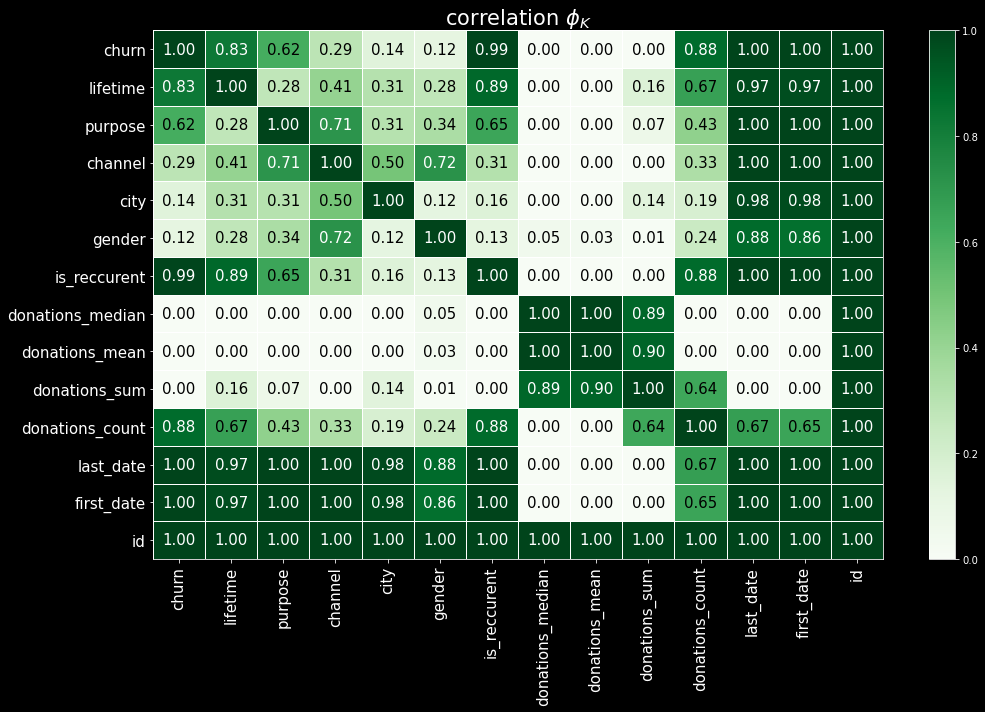

In [33]:
phik_overview = df_new.phik_matrix()
phik_overview['churn'].sort_values(ascending=False)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

In [34]:
# удаляем лишние столбцы(информация есть в столбце lifetime) 
df_new = df_new.drop([ 'first_date', 'last_date', 'id', 'donations_mean', 'last_email_activity'], axis=1)



In [35]:
df_new.columns

Index(['donations_count', 'donations_sum', 'donations_median', 'is_reccurent',
       'gender', 'city', 'channel', 'purpose', 'lifetime', 'churn'],
      dtype='object')

#  Модель CatBoostClassifier

In [36]:

#разбиваем сначала на 2 части обучающую (80) ,тестовую (20)
train, test = train_test_split(df_new, train_size=0.70, random_state=42, stratify = df_new['churn']) 

In [37]:
test['churn'].mean()

0.2972972972972973

In [38]:
train['churn'].mean()

0.29651162790697677

In [39]:
# список призноков
X = [ 'donations_count', 'donations_sum','city', 'donations_median',
       'channel','is_reccurent', 'lifetime', 'gender', 'purpose', ]
    
      
# список целевого признака

y=['churn']

#список категориальных признаков
cat_features =['gender', 'city', 'purpose', 'channel']

In [40]:
params = {'cat_features': cat_features,
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          'learning_rate': 0.01,
          'depth': 2,
          'random_seed': 42,
          'verbose':10,
          'iterations': 500}

In [41]:

train_data = Pool(data=train[X],
                  label=train[y],
                 cat_features=cat_features
                 )

In [42]:
cv_data = cv(
    params = params,
    pool = train_data,
    verbose=False,
    fold_count=5,
    plot="True",
    shuffle=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1
bestIteration = 118

Training on fold [1/5]

bestTest = 1
bestIteration = 58

Training on fold [2/5]

bestTest = 0.9977905435
bestIteration = 241

Training on fold [3/5]

bestTest = 1
bestIteration = 140

Training on fold [4/5]

bestTest = 0.9990740741
bestIteration = 486



In [43]:
cv_data

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.977894,0.011501,0.669730,0.001003,0.669667,0.000776
1,1,0.977232,0.011101,0.648025,0.001781,0.647996,0.001521
2,2,0.978601,0.011139,0.627457,0.002687,0.627402,0.002428
3,3,0.977814,0.011480,0.607383,0.002604,0.607306,0.001784
4,4,0.977953,0.011451,0.587992,0.003067,0.587836,0.001527
...,...,...,...,...,...,...,...
495,495,0.999019,0.001722,0.061411,0.022848,0.048297,0.006984
496,496,0.999019,0.001722,0.061348,0.022855,0.048152,0.007013
497,497,0.999019,0.001722,0.061276,0.022783,0.048070,0.007049
498,498,0.999019,0.001722,0.061200,0.022718,0.047962,0.007092


In [44]:
cv_data[cv_data['test-AUC-mean'] == cv_data['test-AUC-mean'].max()]

,iterations,test-AUC-mean,test-AUC-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
486,486,0.999108,0.001531,0.061691,0.022793,0.048893,0.006944
487,487,0.999108,0.001531,0.061633,0.022745,0.048822,0.006993
488,488,0.999108,0.001531,0.061635,0.022751,0.048809,0.006985
493,493,0.999108,0.001531,0.061490,0.022773,0.048471,0.007041
494,494,0.999108,0.001531,0.061475,0.022758,0.048437,0.007045


In [45]:
params = {'cat_features': cat_features,
          'eval_metric': 'AUC',
          'loss_function': 'Logloss',
          'learning_rate': 0.01,
          'random_seed': 42,
          'verbose':10,
          'iterations': 498,
          }

In [46]:
model = CatBoostClassifier(**params)

In [47]:
plt.style.use('dark_background')
model.fit(train_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 5ms	remaining: 2.48s
10:	total: 20.6ms	remaining: 914ms
20:	total: 32.7ms	remaining: 742ms
30:	total: 45.1ms	remaining: 679ms
40:	total: 60.1ms	remaining: 670ms
50:	total: 74.8ms	remaining: 655ms
60:	total: 84.9ms	remaining: 609ms
70:	total: 98.9ms	remaining: 595ms
80:	total: 115ms	remaining: 591ms
90:	total: 126ms	remaining: 561ms
100:	total: 138ms	remaining: 543ms
110:	total: 151ms	remaining: 527ms
120:	total: 163ms	remaining: 509ms
130:	total: 177ms	remaining: 495ms
140:	total: 189ms	remaining: 479ms
150:	total: 204ms	remaining: 468ms
160:	total: 218ms	remaining: 456ms
170:	total: 230ms	remaining: 440ms
180:	total: 244ms	remaining: 427ms
190:	total: 255ms	remaining: 409ms
200:	total: 267ms	remaining: 394ms
210:	total: 280ms	remaining: 381ms
220:	total: 291ms	remaining: 365ms
230:	total: 308ms	remaining: 356ms
240:	total: 323ms	remaining: 344ms
250:	total: 336ms	remaining: 331ms
260:	total: 350ms	remaining: 318ms
270:	total: 365ms	remaining: 306ms
280:	total: 379ms	remainin

In [48]:
predict_cat = model.predict_proba(test[X])[:, 1]
roc_auc_cat = roc_auc_score(test[y], predict_cat)
accuracy_cat = model.score(test[X], test[y])
print(f"Accuracy на тестовой выборке : {accuracy_cat:.5f}")
print(f"ROC_AUC для модели CatBoost на тестовой выборке: {roc_auc_cat:.5f}")

Accuracy на тестовой выборке : 0.99099
ROC_AUC для модели CatBoost на тестовой выборке: 1.00000


In [49]:
#проверим на адекватность модели
#рассчитываем важность признаков с помощью SHAP
model.get_feature_importance(prettified=True)


,Feature Id,Importances
0,is_reccurent,76.747770
1,donations_count,7.906939
2,lifetime,6.741284
3,city,1.903458
4,purpose,1.810702
5,gender,1.693667
6,donations_sum,1.230919
7,channel,1.178798
8,donations_median,0.786463


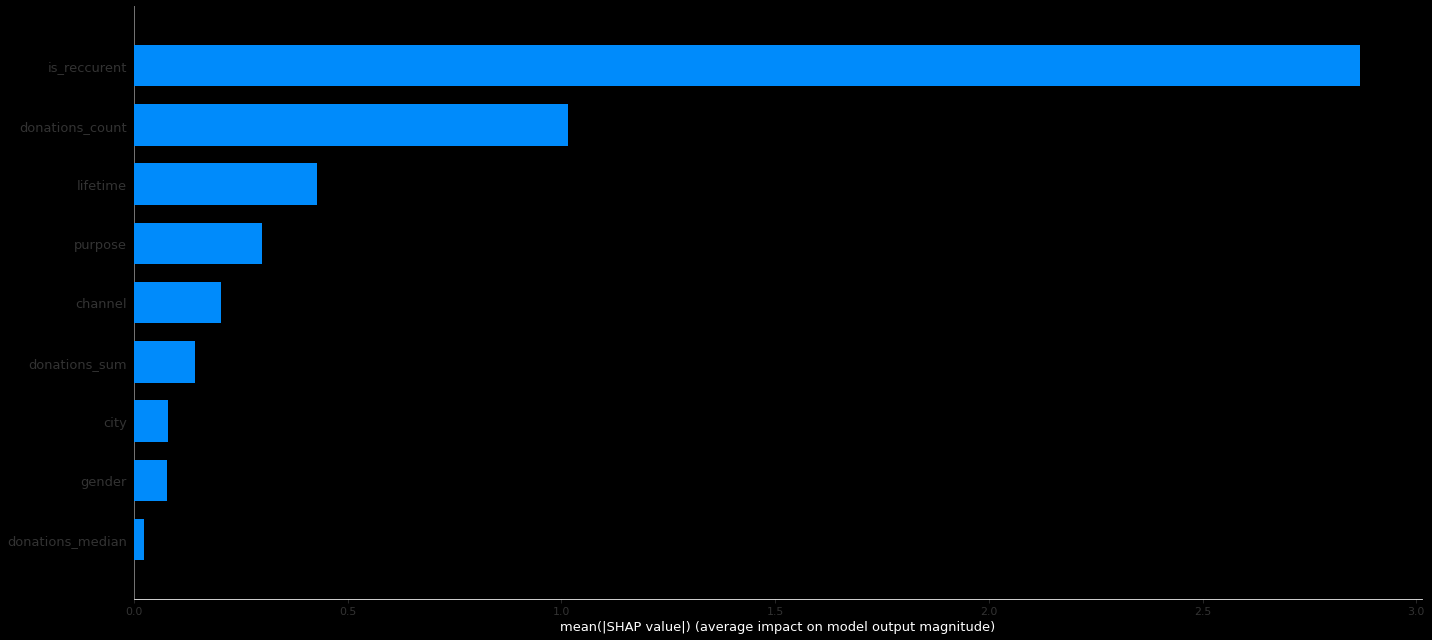

In [50]:
# построим барчарт
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[X])
shap.summary_plot(shap_values, test[X], plot_type="bar", plot_size=(20,9))

In [51]:
# Рассмотрим SHAP-графики. Построим такой график для каждого наблюдения в датасете
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, test[X])

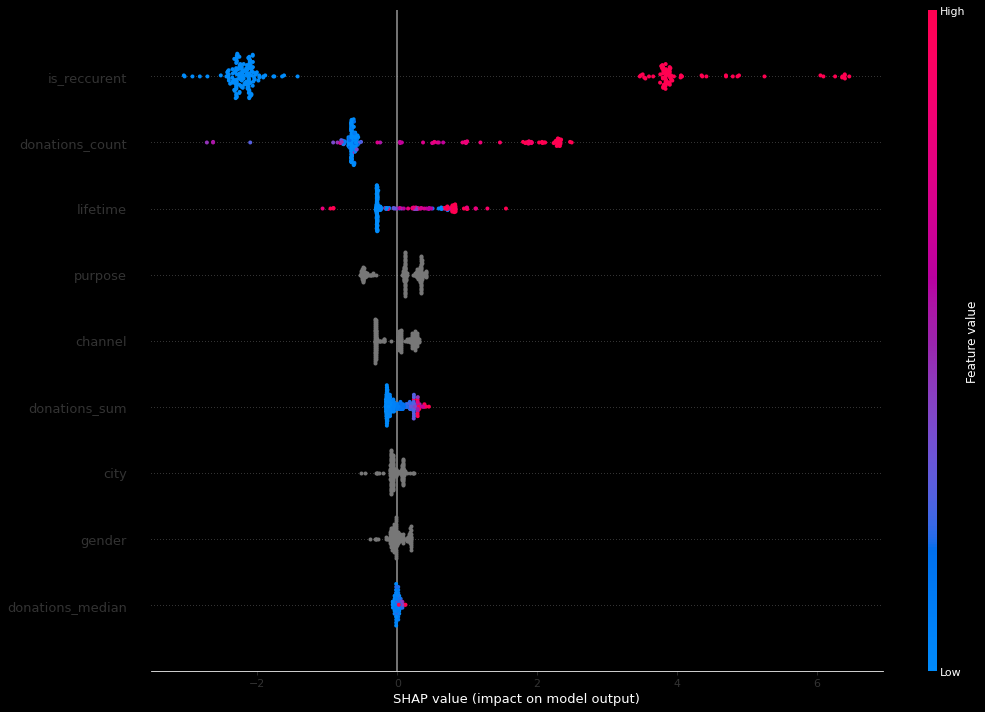

In [62]:
# сортируем объекты по сумме значений SHAP на тестовой выборке 
shap.summary_plot(shap_values, test[X], plot_size=(15,10))

In [53]:
#посмотреть зависимость предсказаний от конкретного признака в виде 2D графика
features = model.get_feature_importance(prettified=True)['Feature Id'].values

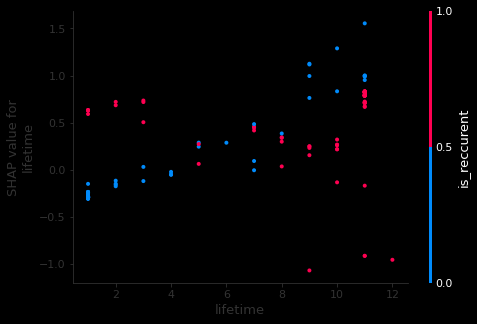

In [54]:
shap.dependence_plot('lifetime', shap_values, test[X])

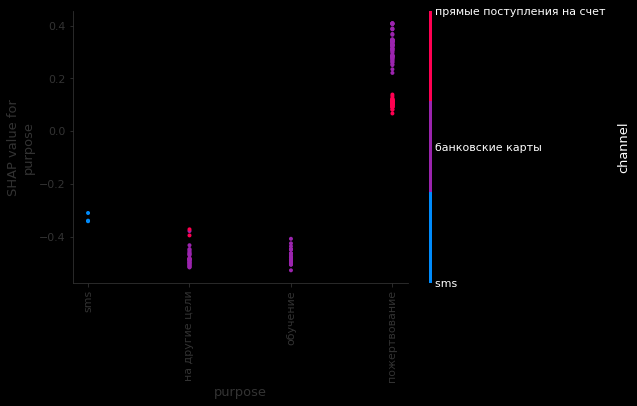

In [55]:
shap.dependence_plot('purpose', shap_values, test[X])

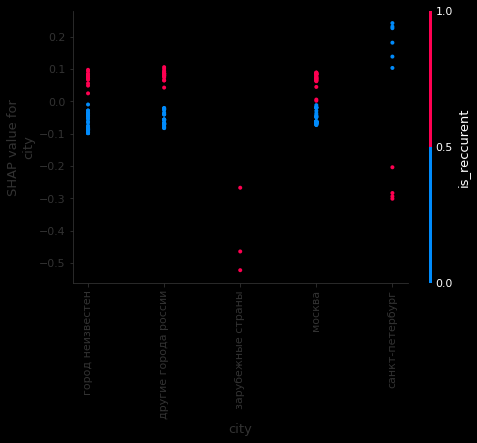

In [56]:
shap.dependence_plot('city', shap_values, test[X])

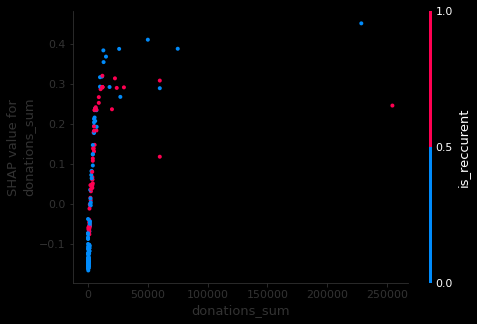

In [57]:
shap.dependence_plot('donations_sum', shap_values, test[X])

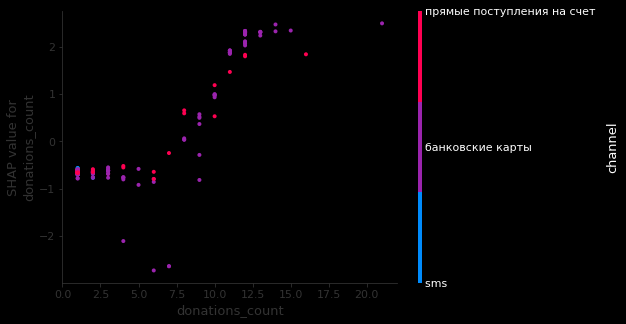

In [58]:
shap.dependence_plot('donations_count', shap_values, test[X])

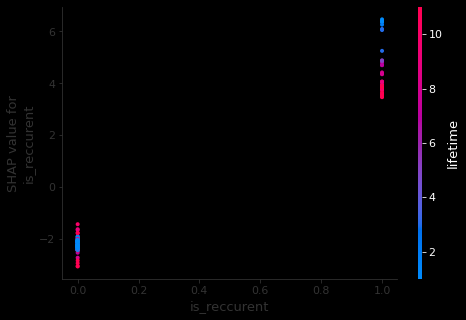

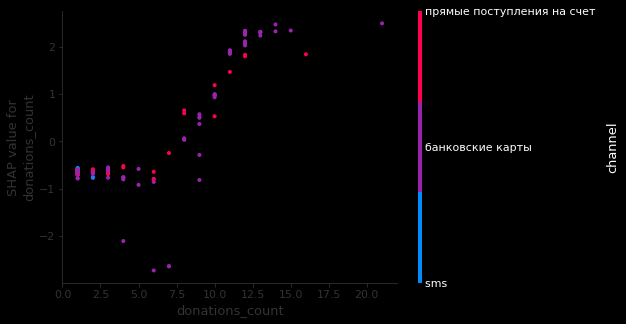

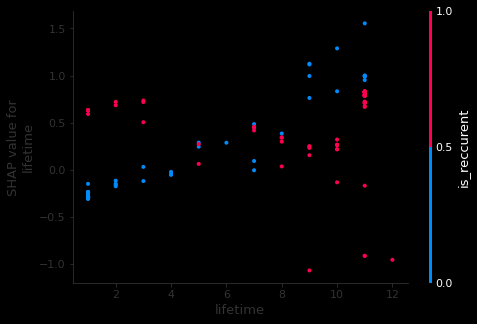

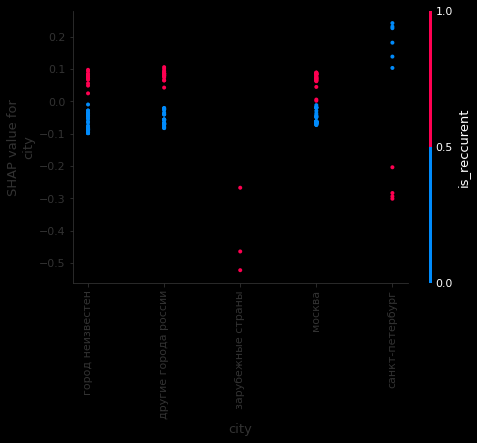

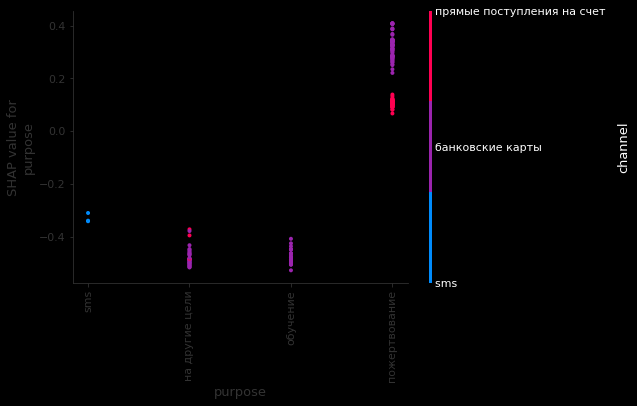

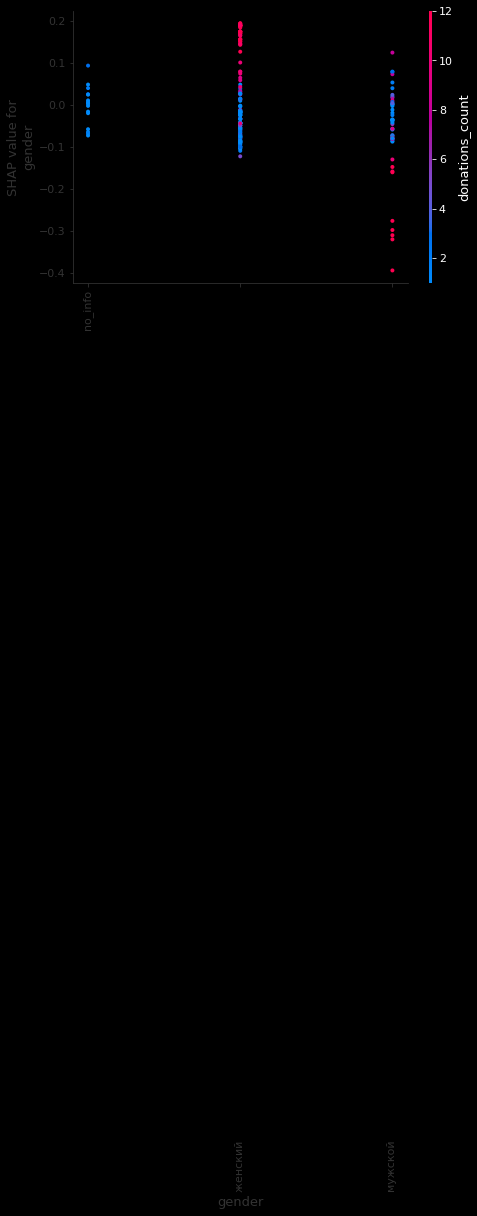

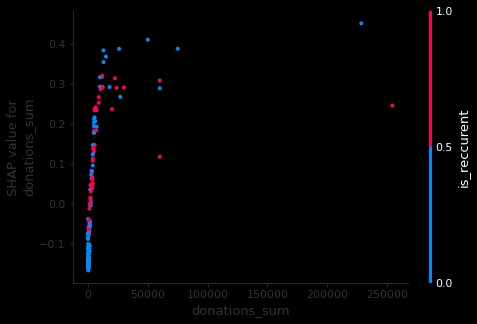

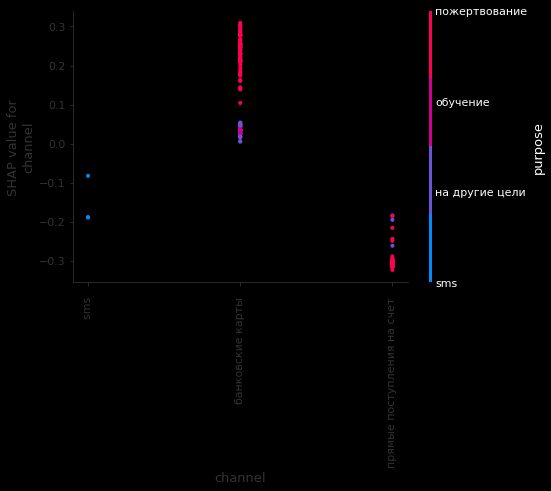

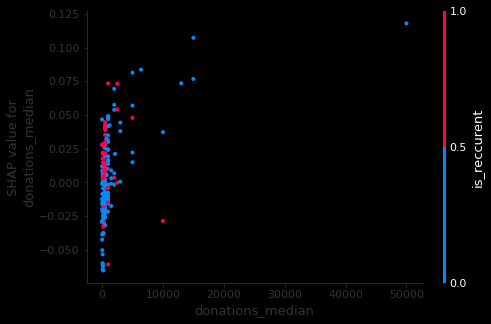

In [59]:
# посмотреть зависимость предсказаний от конкретного признака в виде 2D графика для всех признаков
for features in features:
    shap.dependence_plot(features, shap_values, test[X])

[Text(0.5, 0, 'Predicted'),
 Text(0, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Confusion Matrix Actual vs Predicted')]

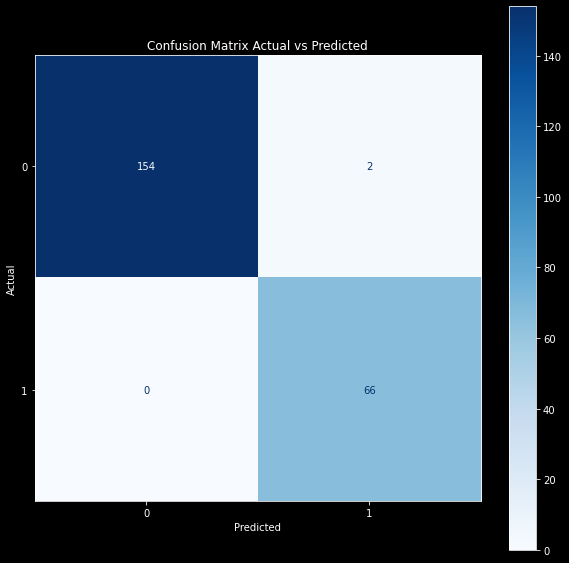

In [60]:

fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(model, test[X], test[y], ax=ax, cmap=plt.cm.Blues)
ax.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix Actual vs Predicted')

In [61]:
len(test)

222